In [1]:
import numpy as np
import cv2
import copy
import os, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt

from tqdm import tqdm
import random

C:\Users\User\Petr\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
from MyUtils import transforms, utils, engine, train as transforms, utils, engine, train
from MyUtils.utils import collate_fn
from MyUtils.engine import train_one_epoch, evaluate
from MyUtils.plot_statistic import plot_stats
from MyUtils.visualize import visualize
import MyUtils.Dataset
from MyUtils.visualize import visualise_tensor

random.seed(42)
torch.manual_seed(42)

In [3]:
#from pprint import pprint
#import json

#with open(os.path.join('C:/Users/User/Petr/Net_2/NEW_DATASET/annotation.json'), 'r') as file:
#    annotations = json.load(file)
#pprint(annotations[0]['annotations'][0]['result'][-1]['value']['x'])

In [4]:
#import shutil

#path = 'C:/Users/User/Petr/Net_2/NEW_DATASET/9c_dataset/'

#images = [file for file in sorted(os.listdir(os.path.join(path, "images")))]
#annotations = [file for file in sorted(os.listdir(os.path.join(path, "annotations"))) if not file=='classes.txt']
#count = 0
#for annotation in annotations:
#    with open(path + 'annotations/' + annotation, 'r') as file:
#        lines = file.readlines()
#        num_corners = len([line for line in lines if line.startswith('0')])
#        if 2 <= num_corners <= 5:
#            shutil.copyfile(path + 'annotations/' + annotation, f'C:/Users/User/Petr/Net_2/NEW_DATASET/5c_dataset/annotations/{annotation}')
#            shutil.copyfile(path + 'images/' + annotation[:-4] + '.jpg', f'C:/Users/User/Petr/Net_2/NEW_DATASET/5c_dataset/images/{annotation[:-4]}.jpg')

In [5]:
#temp_folder = './test_dataset/train/temp/'

#imgs = os.listdir(temp_folder)

#for num, img in enumerate(imgs):
#    os.rename(os.path.join(temp_folder, img), os.path.join(temp_folder, f'dataset_{num + 1}.jpg'))

In [6]:
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=20, always_apply=False, p=0.5),
            A.PixelDropout(dropout_prob=0.005, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=0.5),
            A.Affine(scale=(0.8, 1.0), translate_percent=(-0.1, 0.1), translate_px=None, rotate=0, shear=None, interpolation=1, mask_interpolation=0, cval=0, cval_mask=0, mode=0, fit_output=False, keep_ratio=True, rotate_method='largest_box', always_apply=False, p=0.5),
            #A.RandomScale(scale_limit=[0.1, 0.5], interpolation=1, always_apply=False, p=0.5),
            #A.CropAndPad(px=None, percent=-0.2, pad_mode='BORDER_CONSTANT', pad_cval=100, pad_cval_mask=0, keep_size=False, sample_independently=True, interpolation=1, always_apply=False, p=1.0),
            A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=0.1, brightness_by_max=True, always_apply=False, p=0.5), # Random change of brightness & contrast
            A.RandomShadow(shadow_roi=(0, 0, 1, 1), always_apply=False, p=0.3),
            #A.Solarize(threshold=(200, 200), always_apply=False, p=0.5),
            A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, always_apply=False, p=0.3),
            #A.ToGray(p=1),
            A.InvertImg(p=0.5),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1)
        ])
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def eval_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            #A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.0), contrast_limit=0.0, brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.5, 0.5), p=1)
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

def test_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            #A.RandomBrightnessContrast(brightness_limit=(-0.5, 0.0), contrast_limit=0.0, brightness_by_max=True, always_apply=False, p=1.0), # Random change of brightness & contrast
            #A.InvertImg(p=1),
            #A.ToGray(p=1)
            #A.Sharpen(alpha=(0.1, 0.9), p=1)
        ], p=1)
    ])

Lenght of dataset is 372


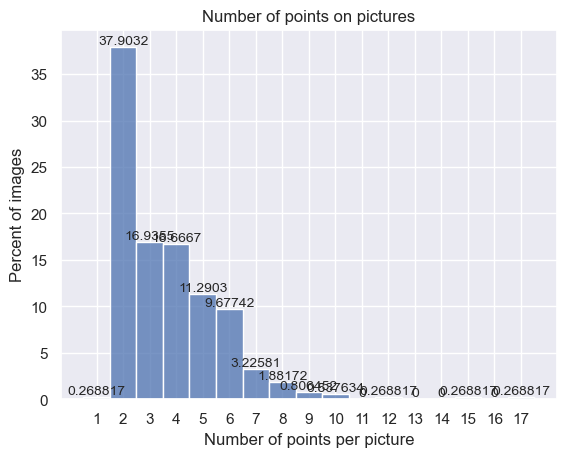

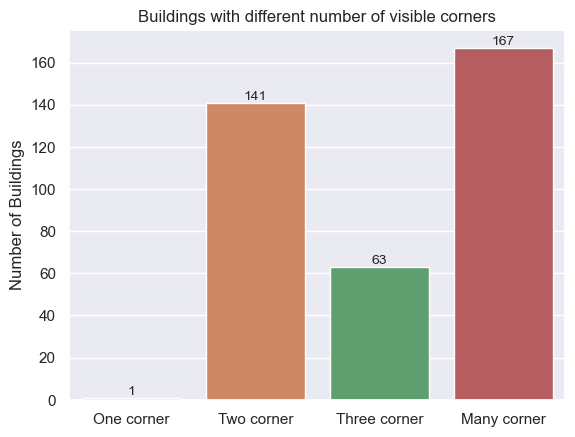

Annotations without buildings:



Annotations with extra buiuldings:



Annotations with errors:




In [7]:
path = 'C:/Users/User/Petr/Net_2/NEW_DATASET'

KEYPOINTS_FOLDER = path
KEYPOINTS_FOLDER_TRAIN = path

dataset = MyUtils.Dataset.NCornerDataset(KEYPOINTS_FOLDER, transform=None, demo=False, N=17)

dataset.explore

TEO_1_00068_Proto_crop_2.jpg
[[[75, 133, 1], [279, 69, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]]


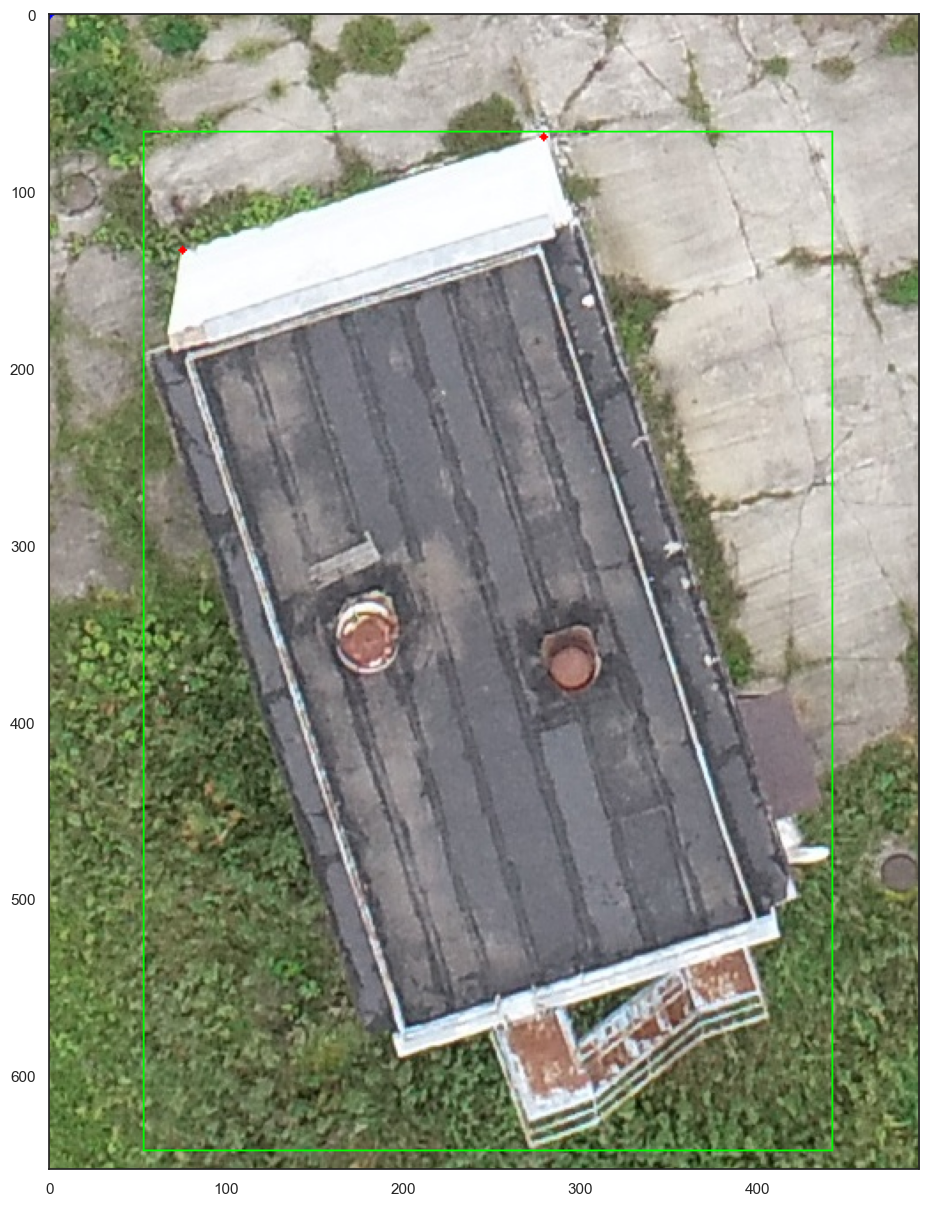

In [8]:
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

idx = torch.IntTensor.item(batch[1][0]['image_id'])

print(dataset.get_image(dataset.annotations[idx]))

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp for kp in kps])

print(keypoints)
visualize(image, bboxes, keypoints)

TEO_4_00787_Voro_crop_0.jpg
[[38, 55, 496, 505]]
[[[318, 501, 1], [40, 377, 1], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0], [524, 563, 0]]]


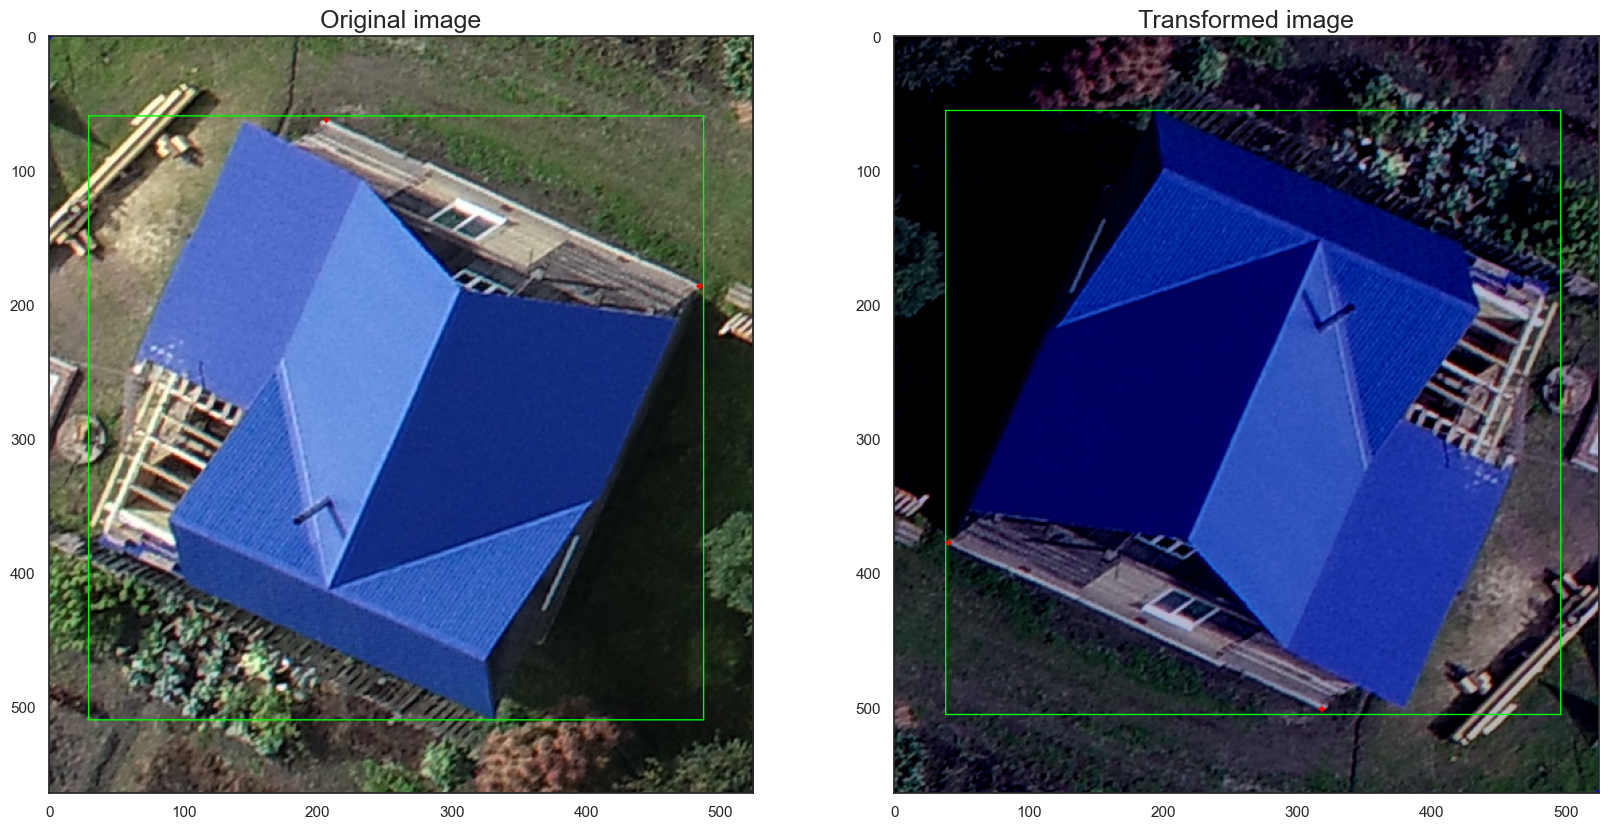

In [9]:
dataset = MyUtils.Dataset.NCornerDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True, N=17)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()
idx = torch.IntTensor.item(batch[1][0]['image_id'])

print(dataset.get_image(dataset.annotations[idx]))

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)
print(bboxes)
print(keypoints)

In [10]:
def get_model(num_keypoints, weights_path=None):
   
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model


def get_model_V2(num_keypoints, weights_path=None):
    from torchvision.ops import MultiScaleRoIAlign
    from torchvision.models.detection import KeypointRCNN
    
    backbone = torchvision.models.mobilenet_v2(weights='DEFAULT').features
    
    backbone.out_channels = 1280
    
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512, 1024),), aspect_ratios=((0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 4.0),))
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)
    
    
    keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],  output_size=14, sampling_ratio=2)
    
    model = KeypointRCNN(backbone, num_classes=2, num_keypoints=num_keypoints, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler, keypoint_roi_pool=keypoint_roi_pooler)#, min_size=400, max_size=2000

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

def get_model_V3(num_keypoints, weights_path=None):
    from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
    from torchvision.models.detection.rpn import AnchorGenerator
    from torchvision.models.detection import keypointrcnn_resnet50_fpn
    # Load a pre-trained model
    model = keypointrcnn_resnet50_fpn(weights='DEFAULT')

# Replace the classifier head with the number of keypoints
    in_features = model.roi_heads.keypoint_predictor.kps_score_lowres.in_channels
    model.roi_heads.keypoint_predictor = KeypointRCNNPredictor(in_channels=in_features, num_keypoints=num_keypoints)

# Set the model's device and data type
    model.name = 'keypointrcnn_resnet50_fpn'
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model
    

In [11]:
#dataset_train_t = MyUtils.Dataset.NCornerDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False, corners=corners, N=10)
#from pprint import pprint
#pprint(dataset_train_t.annotations[842])

In [ ]:
save_path = 'C:/Users/User/Petr/Net_2/save_model'
log_path = 'C:/Users/User/Petr/Net_2/Metric_log'

for num in range(1):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
    
    KEYPOINTS_FOLDER_TRAIN = path
    KEYPOINTS_FOLDER_EVAL = path
    corners = None
    POINTS = max(corners) if corners is not None else 17

    dataset_train = MyUtils.Dataset.NCornerDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False, corners=corners, N=POINTS)
    dataset_test = MyUtils.Dataset.NCornerDataset(KEYPOINTS_FOLDER_EVAL, transform=eval_transform(), demo=False, corners=corners, N=POINTS)

    indices = torch.randperm(len(dataset_train)).tolist()
    thirty_pc = int(len(dataset_train) * 0.15)
    dataset_train = torch.utils.data.Subset(dataset_train, indices[:-thirty_pc])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-thirty_pc:])

    data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
    data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

    model = get_model_V3(num_keypoints = POINTS)#, weights_path='./save_model/weights_rebuild_model_2.pth'


    model.to(device)
    
    #for p in model.parameters():
    #    p.requires_grad = False
    #for p in model.roi_heads.keypoint_head.parameters():
    #    p.requires_grad = True
    #for p in model.roi_heads.keypoint_predictor.parameters():
    #    p.requires_grad = True

    params = [p for p in model.parameters() if p.requires_grad]
    #params1 = [p for p in model.roi_heads.keypoint_head.parameters() if p.requires_grad]
    
    optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.95)#, weight_decay=0.0001
    
    #optimizer = torch.optim.SGD([{'params': params1},
    #                             {'params': model.roi_heads.keypoint_predictor.parameters(), 'lr': .001},], lr=0.001, momentum=0.90)#, weight_decay=0.0001
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
    num_epochs = 51

    kps_stats = []
    bbox_stats = []

    loss_bb = []
    loss_kp = []
    loss = []

    start_from = 0

    for epoch in range(start_from, num_epochs):
        logger = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=int(len(dataset_train) / 10))
        lr_scheduler.step()
        evaluator = evaluate(model, data_loader_test, device)

        kps_stats.append(evaluator.coco_eval['keypoints'].stats[:6])
        bbox_stats.append(evaluator.coco_eval['bbox'].stats[:6])
    
        loss_bb.append(logger.meters['loss_box_reg'].global_avg)
        loss_kp.append(logger.meters['loss_keypoint'].global_avg)
        loss.append(logger.meters['loss'].global_avg)
        
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), f'{save_path}/LS/17c/weights_{epoch+1}_test.pth')
            plot_stats(epoch - start_from + 1, bbox_stats, loss_bb, loss, kps_stats=kps_stats, loss_kp=loss_kp, num=epoch, log_path=log_path)#, num=num
            
    plot_stats(num_epochs - start_from, bbox_stats, loss_bb, loss, kps_stats=kps_stats, loss_kp=loss_kp, num=epoch, log_path=log_path)
#print(type(meters[0]['loss_keypoint']))

# Save model weights after training
#torch.save(model.state_dict(), './save_model/weights_2.pth')
    #torch.save(model.state_dict(), f'{save_path}/2c/weights_2c_re_1000.pth')

Epoch: [0]  [  0/159]  eta: 0:01:39  lr: 7.323e-06  loss: 8.5267 (8.5267)  loss_classifier: 0.3053 (0.3053)  loss_box_reg: 0.0911 (0.0911)  loss_keypoint: 8.0361 (8.0361)  loss_objectness: 0.0756 (0.0756)  loss_rpn_box_reg: 0.0185 (0.0185)  time: 0.6274  data: 0.0457  max mem: 7178
Epoch: [0]  [ 31/159]  eta: 0:00:57  lr: 2.033e-04  loss: 8.2223 (8.3334)  loss_classifier: 0.0797 (0.1519)  loss_box_reg: 0.0779 (0.0800)  loss_keypoint: 8.0182 (8.0461)  loss_objectness: 0.0081 (0.0425)  loss_rpn_box_reg: 0.0103 (0.0129)  time: 0.3952  data: 0.0707  max mem: 9131
Epoch: [0]  [ 62/159]  eta: 0:00:42  lr: 3.993e-04  loss: 7.8114 (8.1212)  loss_classifier: 0.0403 (0.1045)  loss_box_reg: 0.0547 (0.0721)  loss_keypoint: 7.6796 (7.9076)  loss_objectness: 0.0056 (0.0252)  loss_rpn_box_reg: 0.0050 (0.0118)  time: 0.4299  data: 0.0729  max mem: 9131
Epoch: [0]  [ 93/159]  eta: 0:00:29  lr: 5.953e-04  loss: 6.8525 (7.7920)  loss_classifier: 0.0395 (0.0827)  loss_box_reg: 0.0500 (0.0646)  loss_keypoi

In [ ]:
KEYPOINTS_FOLDER = path
save_path = 'C:/Users/User/Petr/Net_2/save_model'
corners = None
POINTS = max(corners) if corners is not None else 17

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_test = get_model_V3(num_keypoints=POINTS, weights_path=f'{save_path}/LS/17c/weights_1160.pth')
model_test.to(device);

In [7]:
test_path = 'C:/Users/User/Petr/Net_2/check_model/Rod/images/'
save_path = 'C:/Users/User/Petr/Net_2/check_model/Rod/pred/'
#model_test = model
import pandas as pd
classes = {'Building': 1}
inv_classes = {value:key for key, value in classes.items()}
for image in tqdm(os.listdir(test_path)):
    #if image != 'ZON_1_00004_Rod_crop_1.jpg':
    #    continue
    img = cv2.imdecode(np.fromfile(os.path.join(test_path, image), dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(os.path.join(test_path, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_orig = cv2.imdecode(np.fromfile(os.path.join(test_path, image), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    
    img = F.to_tensor(img)
    #type(img)
    img = img.to(device)
    with torch.no_grad():
        model_test.to(device)
        model_test.eval()
        out = model_test([img,])
        out = out[0]

    #print(img.shape, img.dtype)
    image_t = img.detach().cpu().numpy()
    image_t = image_t.transpose(1,2,0) * 255
    image_t = image_t.astype(np.uint8)
    image_t = cv2.cvtColor(image_t, cv2.COLOR_BGR2RGB)
    
    scores_valid = out['scores'] > 0.95
    
    target = {}
    target['boxes'] = out['boxes'][scores_valid]
    target['scores'] = out['scores'][scores_valid]
    target['labels'] = out['labels'][scores_valid]
    target['keypoints'] = out['keypoints'][scores_valid]
    target['keypoints_scores'] = out['keypoints_scores'][scores_valid]

    valid_kps = target['keypoints_scores'][:] > 8.0

    keypoints = []
    
    final_target = {}
    final_target['boxes'] = target['boxes']
    final_target['scores'] = target['scores']
    final_target['labels'] = target['labels']
    final_target['keypoints'] = target['keypoints'][valid_kps]
    final_target['keypoints_scores'] = target['keypoints_scores'][valid_kps]

    #sprint(final_target)

    visualise_tensor(image=img, final_target=final_target, path=save_path+image)

100%|██████████| 3666/3666 [04:14<00:00, 14.43it/s]


In [ ]:
df.head()

In [ ]:
for rect in df.itertuples():
    print(rect.xmin)

In [ ]:
!pip install Metashape